# Models
(arranjar um nome melhor para o notebook)

Notebook para o treinamento de modelos

In [1]:
import random

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models
import sklearn
import sktime
import keras
import statsmodels.api as sm
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from tensorflow import keras
from tensorflow.keras import layers

# model selection and metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsoluteError

# variables
processed_data_path = '../data/processed-data/'

2023-03-25 16:53:31.731694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 16:53:32.572166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 16:53:32.572191: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-25 16:53:35.044497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Auxiliary Functions

In [2]:
def plot_time_series(df, groupby = 'median', cols = ['target1', 'target2', 'target3', 'target4']):
    df_melted = df.groupby('Dt').median()[cols]\
    .melt(var_name='target', value_name='value', ignore_index=False)
    df_melted.reset_index(inplace=True)

    sns.set(rc={'figure.figsize':(10,20)})
    sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
    .map(sns.lineplot, 'Dt', 'value');

In [3]:
def plot_train_test_pred(train, test, pred = pd.DataFrame(), groupby = 'median', cols = ['target1', 'target2', 'target3', 'target4']):
    train['type'] = 'train'
    test['type'] = 'test'
    pred['type'] = 'pred'
    
    cols.append('type')

    df = pd.concat([train, test, pred], axis=0)
    df_melted = df.groupby('Dt').median()[cols]\
        .melt(var_name='target', value_name='value', ignore_index=False)
    df_melted.reset_index(inplace=True)
    
    sns.set(rc={'figure.figsize':(10,20)})
    sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
        .map(sns.lineplot, 'Dt', 'value', hue='type');

## Data Preparation

Apenas realizar modificações necessárias para os modelos como *splitting* dos datasets e normalização. Toda a limpeza de dados deve ser feita em **/src/data-engineering/data-preparation**

### Loading the data

In [4]:
df_targets = pd.read_pickle(processed_data_path + 'targets.pkl')

### Train Test Split

In [5]:
train, test = temporal_train_test_split(df_targets, test_size=0.2)

In [6]:
train.shape

(2004940, 6)

In [7]:
test.shape

(501236, 6)

In [8]:
trg_cols = ['target1', 'target2', 'target3', 'target4']
train_median_melted = train.groupby('Dt').median()[trg_cols]\
    .reset_index()\
    .melt(var_name='target', value_name='value', ignore_index=False)


In [9]:
cols = ['target1', 'target2', 'target3', 'target4']
pred = pd.DataFrame()
train['type'] = 'train'
test['type'] = 'test'
pred['type'] = 'pred'

# cols.append('type')

df = pd.concat([train, test, pred], axis=0)
# df_melted = df.groupby('Dt').median()[cols]\
#     .melt(var_name='target', value_name='value', ignore_index=False)
# df_melted.reset_index(inplace=True)

# sns.set(rc={'figure.figsize':(10,20)})
# sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
#     .map(sns.lineplot, 'Dt', 'value', hue='type');

In [10]:
group = df.groupby('Dt').median()[cols]
group

,target1,target2,target3,target4
Dt,,,,
2018-01-01,0.000000,1.556420,0.000000,0.441176
2018-01-02,0.000000,0.867444,0.000000,0.330827
2018-01-03,0.000000,0.801282,0.000000,0.386930
2018-01-04,0.000000,1.043176,0.000000,0.552486
2018-01-05,0.000000,0.489579,0.000000,0.213630
...,...,...,...,...
2021-04-26,0.001136,0.166169,0.002621,0.341915
2021-04-27,0.000691,0.157964,0.003097,0.458015
2021-04-28,0.000697,0.239898,0.001343,0.392238


In [11]:
types = df[['Dt', 'type']].drop_duplicates()
types

,Dt,type
0,2018-01-01,train
2061,2018-01-02,train
4122,2018-01-03,train
6183,2018-01-04,train
8244,2018-01-05,train
...,...,...
2495871,2021-04-26,test
2497932,2021-04-27,test
2499993,2021-04-28,test
2502054,2021-04-29,test


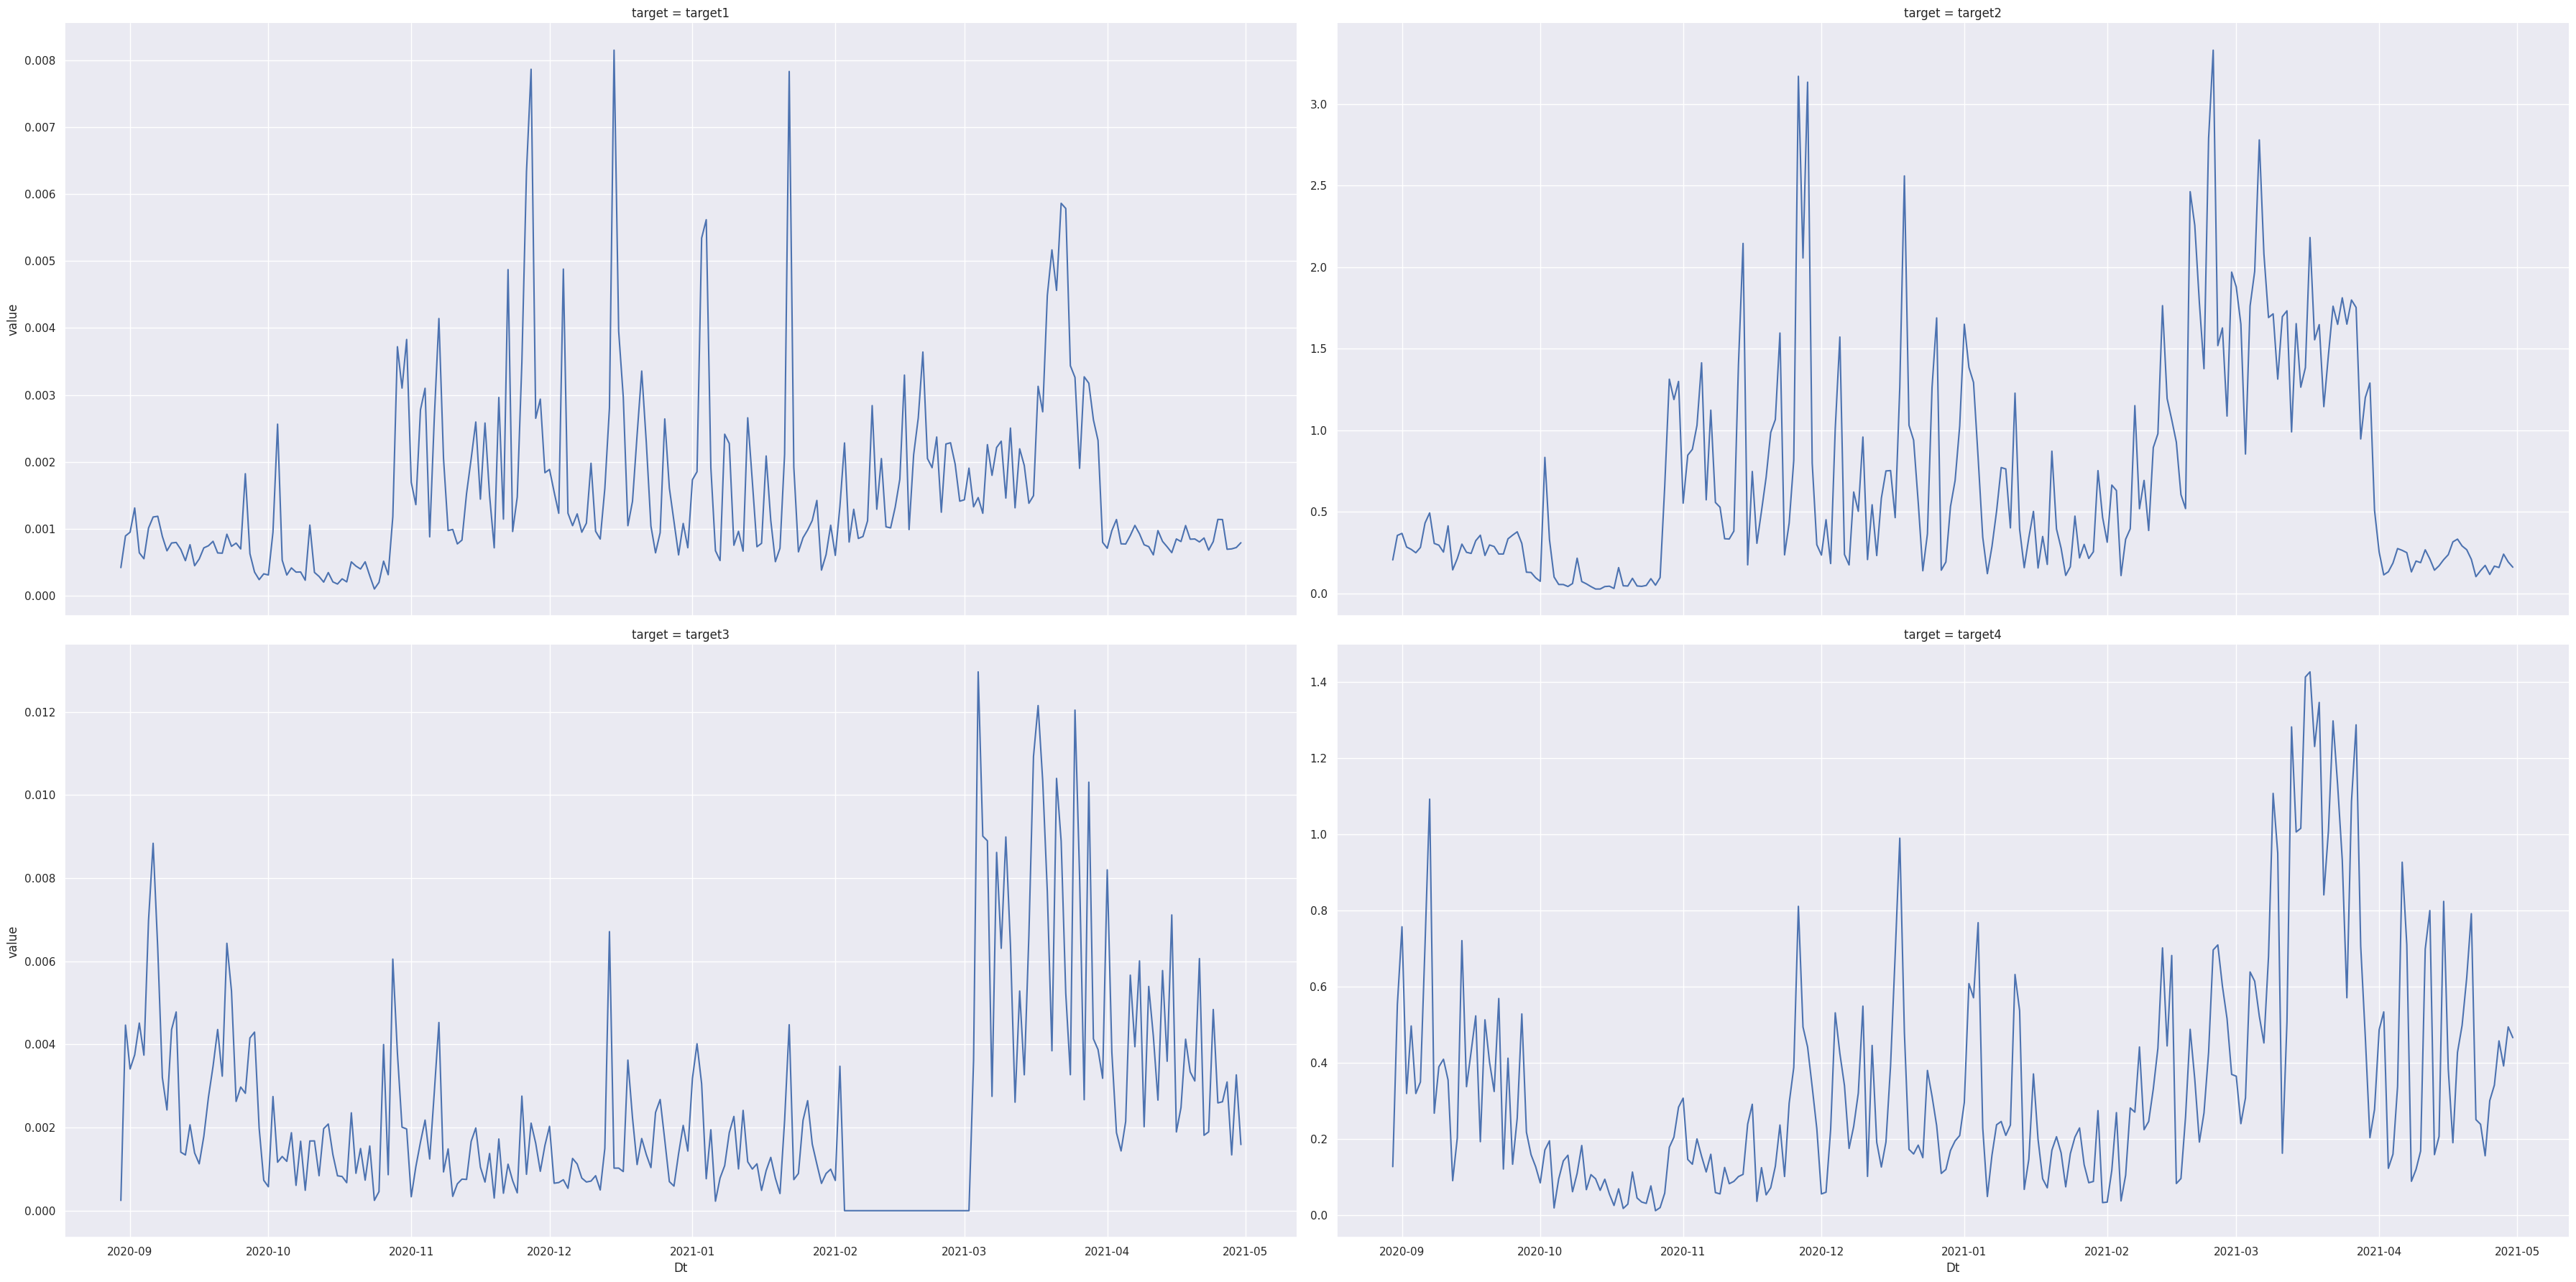

In [ ]:
plot_time_series(test)

### Train-test-validation split

### Data Normalization

## Training

In [24]:
def train_model(model, train, test, y_cols = ['target1', 'target2', 'target3', 'target4']):
    results = {}
    for col in y_cols:
        y_train = train[col].set_axis(train['Dt'])
        y_test = test[col].set_axis(test['Dt'])
        model.fit(y_train)
        pred = model.predict(y_test)
        results[col] = pred
    return results

In [36]:
def train_baseline_model(model, train, fh_size, y_cols = ['target1', 'target2', 'target3', 'target4']):
    results = {}
    fh = np.arange(len(fh_size)) + 1
    for col in y_cols:
        y_train = train[col].set_axis(train['Dt'])
        model.fit(y_train)
        pred = model.predict(fh)
        results[col] = pred
    return results

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004940 entries, 0 to 2004939
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Dt        datetime64[ns]
 1   IdPlayer  int64         
 2   target1   float32       
 3   target2   float32       
 4   target3   float32       
 5   target4   float32       
 6   type      object        
dtypes: datetime64[ns](1), float32(4), int64(1), object(1)
memory usage: 91.8+ MB


In [39]:
model = NaiveForecaster(strategy='last')
col = 'target1'
fh = train.shape[0]
y_train = train[col].set_axis(train['Dt'])
# y_train
model.fit(y_train)
pred = model.predict(fh)

TypeError: unsupported operand type(s) for *=: 'int' and 'NoneType'

In [27]:
test.shape[0]

501236

In [29]:
train_baseline_model(NaiveForecaster(strategy='last'), train, test.shape[0])

TypeError: unsupported operand type(s) for *=: 'int' and 'NoneType'

In [ ]:
# # Naive
# naive = NaiveForecaster(strategy='last').fit(train)
# y_pred_naive = naive.predict(test)

# # Mean
# mean = NaiveForecaster(strategy="mean").fit(train)
# y_pred_mean = mean.predict(test)

# # Drift
# drift = NaiveForecaster(strategy="drift").fit(train)
# y_pred_drift = drift.predict(test)

TypeError: y must be in an sktime compatible format, of scitype Series, Panel or Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynb,If you think y is already in an sktime supported input format, run sktime.datatypes.check_raise(y, mtype) to diagnose the error, where mtype is the string of the type specification you want for y. Possible mtype specification strings are as follows. "For Hierarchical scitype: ['pd_multiindex_hier']. 

### Baseline Models

## Model Evaluation